# <center> Практика. Статистические тесты в контексте EDA

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

In [163]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Описательный анализ данных

In [298]:
data = pd.read_csv('ds_salaries.csv')
data = data.drop(['Unnamed: 0'], axis = 1 )
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [165]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 52.3+ KB


В дата-сете  607 значений, нет пропущенных данных. 

Столбцы содержат следующие данные:
* <i>work_year </i>- Год, в котором была выплачена зарплата.
* <i> experience_level </i> -	Опыт работы на этой должности в течение года со следующими возможными значениями:\
 EN — Entry-level/Junior;\
MI — Mid-level/Intermediate;\
SE — Senior-level/Expert;\
EX — Executive-level/Director.
* <i> employment_type </i> - Тип трудоустройства для этой роли:\
PT — неполный рабочий день;\
FT — полный рабочий день;\
CT — контракт;\
FL — фриланс.
* <i>job_title</i> -	Роль, в которой соискатель работал в течение года.
* <i>salary</i>	- Общая выплаченная валовая сумма заработной платы.
* <i>salary_currency </i> -	Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* <i>salary_in_usd</i> - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* <i>employee_residence	</i> - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* <i>remote_ratio</i> -	Общий объём работы, выполняемой удалённо. Возможные значения:\
0 — удалённой работы нет (менее 20 %);\
50 — частично удалённая работа;\
100 — полностью удалённая работа (более 80 %).
* <i>company_location</i> -	Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* <i>company_size<i> - Среднее количество людей, работавших в компании в течение года:\
S — менее 50 сотрудников (небольшая компания);\
M — от 50 до 250 сотрудников (средняя компания);\
L — более 250 сотрудников (крупная компания). 

Проверим дата-сет на дубликаты и удалим повторяющиеся данные:

In [299]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


### Распределение заработных плат

Так как для анализа данных по заработной плате нам необходима информация в рамках одной валюты, мы будем использовать столбец salary_in_usd

In [300]:
data = data.drop(['salary', 'salary_currency'], axis = 1)

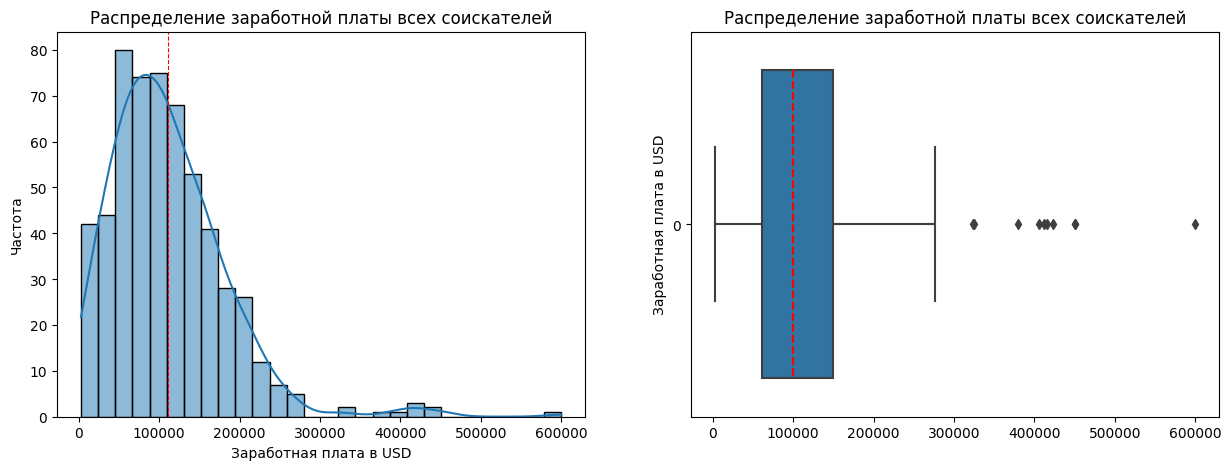

In [168]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Заработная плата в USD', ylabel='Частота')
axes[0].set_title('Распределение заработной платы всех соискателей')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Заработная плата в USD')
axes[1].set_title('Распределение заработной платы всех соискателей')

plt.show()

![](salary_distr.png)

In [301]:
display(data['salary_in_usd'].describe().round(2).to_frame())
display("Соискатели с зарплатой выше 350K USD:", data[data['salary_in_usd']>350000])

,salary_in_usd
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


'Соискатели с зарплатой выше 350K USD:'

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
33,2020,MI,FT,Research Scientist,450000,US,0,US,M
63,2020,SE,FT,Data Scientist,412000,US,100,US,L
97,2021,MI,FT,Financial Data Analyst,450000,US,100,US,L
157,2021,MI,FT,Applied Machine Learning Scientist,423000,US,50,US,L
225,2021,EX,CT,Principal Data Scientist,416000,US,100,US,S
252,2021,EX,FT,Principal Data Engineer,600000,US,100,US,L
519,2022,SE,FT,Applied Data Scientist,380000,US,100,US,L
523,2022,SE,FT,Data Analytics Lead,405000,US,100,US,L


По данным графикам, мы видим, что медианная з/п чуть выше 100K долларов, при этом есть соискатели c з/п 2850 и с з/п 350К-600K.\
Сделав проверку, мы видим, что зарплата выше 350К у специалистов Middle и выше с локацией в США. Данные выглядят нормально.

### Заработная плата в зависимости от страны и опыту работы

In [170]:
data['employee_residence'].nunique()

57

In [302]:
data_agg = data.groupby('employee_residence')['salary_in_usd'].describe().round(2).sort_values('mean', ascending=False)
print('Заработная плата в зависимости от локации (количество соискателей более 10)')
data_agg[data_agg['count']>10]

Заработная плата в зависимости от локации (количество соискателей более 10)


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
US,295.0,150094.92,70918.56,25000.0,105200.00,138000.0,175550.00,600000.0
CA,27.0,97191.63,40151.79,52000.0,71349.00,85000.0,110397.50,196979.0
DE,24.0,85336.67,40215.64,15966.0,62411.25,78015.0,94859.50,173762.0
GB,43.0,81470.07,30283.75,37300.0,55247.00,78526.0,103931.00,183228.0
FR,18.0,59886.61,15848.69,36643.0,49734.50,57920.0,69342.50,93427.0
ES,15.0,57593.40,28395.03,10354.0,41371.00,49461.0,71444.50,130800.0
GR,12.0,56445.75,21544.77,20000.0,43021.75,52209.0,70556.00,88654.0
IN,30.0,37322.33,43741.19,5409.0,16397.00,22124.0,38812.75,200000.0


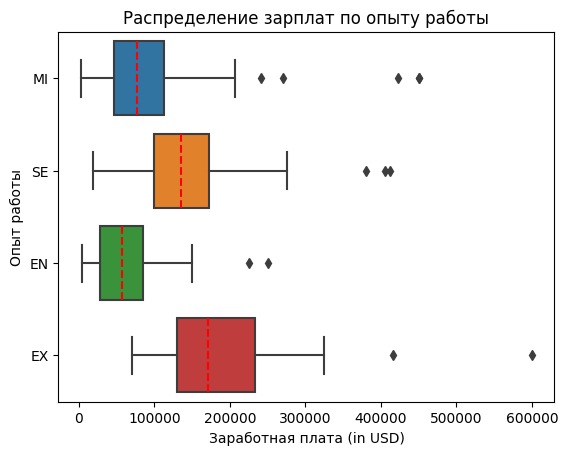

In [303]:
ax = sns.boxplot(data, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Заработная плата (in USD)', ylabel='Опыт работы')
plt.title('Распределение зарплат по опыту работы')
plt.show()

![](salary_to_exp.png)

Мы проанализировали общую информацию по заработной плате в зивисимости от локации и опыта работы.\
По локации были отобраны страны, где у нас есть данные по 10+ сотрудникам, чтобы увидеть средние значения. Как мы видим, самые высокие показатели зарплаты в США, в от время как самые низки - в Индии.\
По данным относительно опыта работы видно, что с увеличением опыта, растет заработная плата. Распределение нормальное, есть выбросы. 

## Корреляция значений

Рассмотрим корреляцию между показателями таблицы, для этого приведем категориальные значения нужному цифровому формату.

In [304]:
import category_encoders as ce 

# создаем объект OrdinalEncoder, col - имя столбца, mapping - словарь с описанием кодировки
data_encoder1 = ce.OrdinalEncoder(mapping=[{
	'col': 'experience_level',
	'mapping': {'EN': 1, 'MI': 2, 'SE': 3, 
                'EX': 4}
}])
# применяем трансформацию к столбцу
data_bin = data_encoder1.fit_transform(data[['experience_level']])
# добавляем результат к исходному DataFrame
data_encoded = pd.concat([data, data_bin], axis=1)

In [305]:
data_encoder2 = ce.OrdinalEncoder(mapping=[{
    'col': 'company_size',
    'mapping': {'S' : 1, 'M' : 2, 'L' : 3}
}])
data_bin2 = data_encoder2.fit_transform(data_encoded[['company_size']])
data_encoded = pd.concat([data_encoded, data_bin2], axis = 1)
data_encoded.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,experience_level,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L,2,3
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S,3,1
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M,3,2
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S,2,1
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L,3,3


In [306]:
bin_encoder = ce.BinaryEncoder(cols=['employment_type']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data_encoded['employment_type'])
data_encoded = pd.concat([data_encoded, type_bin], axis=1)

data_encoded

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,experience_level,company_size,employment_type_0,employment_type_1,employment_type_2
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L,2,3,0,0,1
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S,3,1,0,0,1
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M,3,2,0,0,1
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S,2,1,0,0,1
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L,3,3,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,US,100,US,M,3,2,0,0,1
603,2022,SE,FT,Data Engineer,126000,US,100,US,M,3,2,0,0,1
604,2022,SE,FT,Data Analyst,129000,US,0,US,M,3,2,0,0,1
605,2022,SE,FT,Data Analyst,150000,US,100,US,M,3,2,0,0,1


Так как нам необходимо будет проверить связь между должностью и зарплатой, посмотрим, какие должности представлены в датасете.

In [307]:
data['job_title'].unique()

array(['Data Scientist', 'Machine Learning Scientist',
       'Big Data Engineer', 'Product Data Analyst',
       'Machine Learning Engineer', 'Data Analyst', 'Lead Data Scientist',
       'Business Data Analyst', 'Lead Data Engineer', 'Lead Data Analyst',
       'Data Engineer', 'Data Science Consultant', 'BI Data Analyst',
       'Director of Data Science', 'Research Scientist',
       'Machine Learning Manager', 'Data Engineering Manager',
       'Machine Learning Infrastructure Engineer', 'ML Engineer',
       'AI Scientist', 'Computer Vision Engineer',
       'Principal Data Scientist', 'Data Science Manager', 'Head of Data',
       '3D Computer Vision Researcher', 'Data Analytics Engineer',
       'Applied Data Scientist', 'Marketing Data Analyst',
       'Cloud Data Engineer', 'Financial Data Analyst',
       'Computer Vision Software Engineer',
       'Director of Data Engineering', 'Data Science Engineer',
       'Principal Data Engineer', 'Machine Learning Developer',
       

Мы видим, что в основном представлены специалисты Data Science, Data Engineering и Data Analyst.\
Приведем к следующим категориям:\
1 - Data Science\
2 - Data Engineering\
3 - Data Analytics\
4 - Other

In [308]:
data_encoded['job'] = data_encoded['job_title'].apply(lambda x: 1 if 'Data Scie' in x else (2 if 'Data Eng' in x else (3 if 'Ana' in x else 4)))


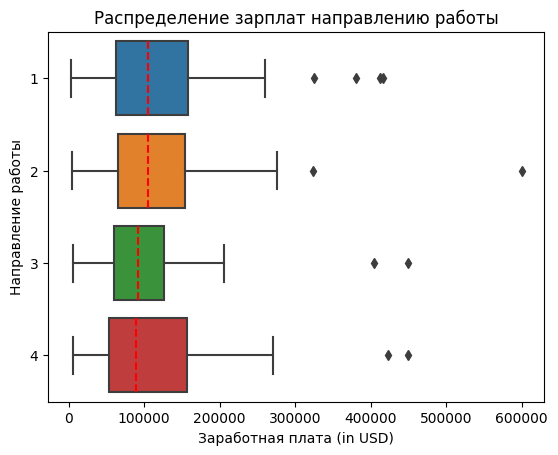

In [309]:
ax = sns.boxplot(data_encoded, x='salary_in_usd', y='job', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Заработная плата (in USD)', ylabel='Направление работы')
plt.title('Распределение зарплат направлению работы')
plt.show()

![](salary_to_area.png)

In [285]:
data_encoded.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,experience_level,company_size,employment_type_0,employment_type_1,employment_type_2,job
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L,2,3,0,0,1,1
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S,3,1,0,0,1,1
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M,3,2,0,0,1,2
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S,2,1,0,0,1,3
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L,3,3,0,0,1,2


C:\Users\tanya\AppData\Local\Temp\ipykernel_22752\40151301.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_encoded.corr(), annot=True, linewidths=.5, ax=ax)


<Axes: >

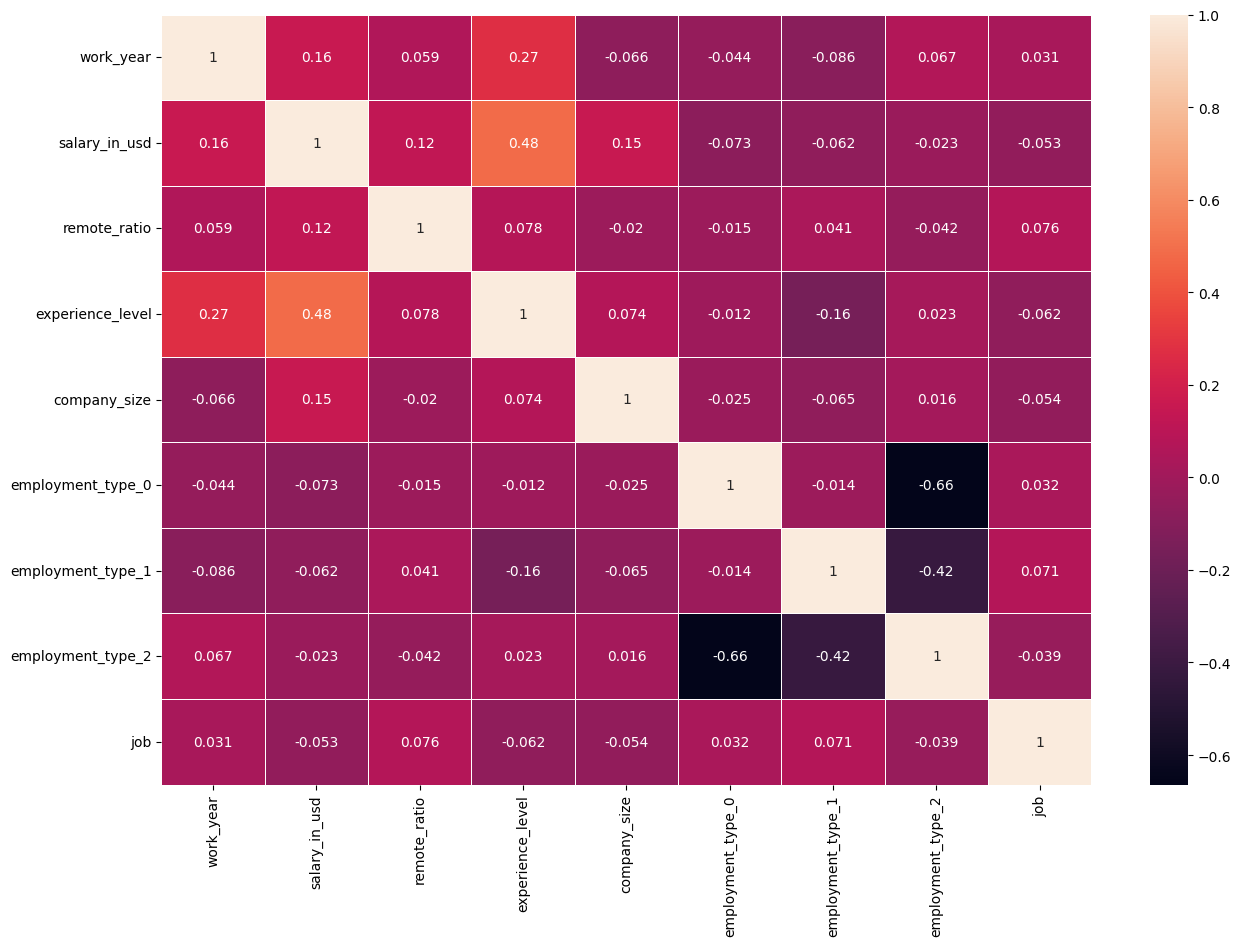

In [310]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data_encoded.corr(), annot=True, linewidths=.5, ax=ax)

![](corr1.png)

Как мы видим, самая высокая прямая зависимость между заработной платой и опытом работы. При этом остальные рассматриваемые показатели никак не влияют на зарплату сотрудником (корреляция очень низкая).\
Чуть меньше наблюдается интересная корреляция между годом, в котором была выплачена зарплата, и опытом работы.


## Статистический анализ данных

In [204]:
# функция для принятия решения о нормальности
def decision_normality(p):
    alpha = 0.05
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    alpha = 0.05
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Зарплата зависит от опыта работы?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплаты не отличается в зависимости от опыта сотрудника: Junior ($μ_1$), Middle ($μ_2$), Senior ($μ_3$), Executive ($μ_4$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза*: размер зарплаты отличается в зависимости от опыта сотрудника: Junior ($μ_1$), Middle ($μ_2$), Senior ($μ_3$), Executive ($μ_4$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

Так как мы видим, что данный признак является порядковым, за основу возьмем таблицу, где он уже преобразован в числовое значение

In [311]:
data1 = data.copy()
data1['experience_level'] = data['experience_level'].replace(['EN', 'MI', 'SE', 'EX'], [1, 2, 3, 4])

In [312]:
# значения страховых выплат
salary_en = data1.loc[data1['experience_level']==1, 'salary_in_usd']
salary_mi = data1.loc[data1['experience_level']==2, 'salary_in_usd']
salary_se = data1.loc[data1['experience_level']==3, 'salary_in_usd']
salary_ex = data1.loc[data1['experience_level']==4, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Entry-Junior:')
result = stats.shapiro(salary_en)
decision_normality(result[1])

print('Для Middle:')
result = stats.shapiro(salary_mi)
decision_normality(result[1])

print('Для Senior:')
result = stats.shapiro(salary_se)
decision_normality(result[1])

print('Для Executive:')
result = stats.shapiro(salary_ex)
decision_normality(result[1])


Для Entry-Junior:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Middle:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Senior:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Executive:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Опыт работы»? — Категориальный (порядковый).
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краксела — Уоллиса.

**Проведем тест**

In [313]:
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05 

# проводим тест
_, p = stats.kruskal(salary_en, salary_mi, salary_se, salary_ex)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

У нас есть основания утверждать, что зарплата зависит от опыта работы сотрудника.

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплаты не отличается в зависимости от года: 2020 ($μ_1$), 2021 ($μ_2$), 2022($μ_3$). 

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер зарплаты отличается в зависимости от года: 2020 ($μ_1$), 2021 ($μ_2$), 2021 ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 $$



In [314]:
# значения страховых выплат
year_20 = data_encoded.loc[(data_encoded['work_year']==2020) & (data_encoded['job']==1), 'salary_in_usd']
year_21 = data_encoded.loc[(data_encoded['work_year']==2021) & (data_encoded['job']==1), 'salary_in_usd']
year_22 = data_encoded.loc[(data_encoded['work_year']==2022) & (data_encoded['job']==1), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(year_20)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(year_21)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(year_22)
decision_normality(result[1])



Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2022:
p-value = 0.038
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака "Размер зарплаты"? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краксела — Уоллиса.

**Проведем тест**

In [315]:
# задаём уровень значимости
alpha = 0.05 

# проводим тест
_, p = stats.kruskal(year_20, year_21, year_22)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод**

У нас есть основания утверждать, что зарплата сотрудников Data Science изменилась за 3 года.\
Также по ранее составленному графику корреляций мы можем наблюдать прямую зависимость, соостветственно, зарплаты растут.

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер зарплаты Data Scientist ($μ_1$) больше или равен зарплатам Data Engineer ($μ_2$). 

$$ H_0 : μ_1 >= μ_2 $$

*Альтернативная гипотеза*: размер зарплаты Data Scientist ($μ_1$) и Data Engineer ($μ_2$) не равны.

$$ H_1 : μ_1 < μ_2 $$



In [316]:
# значения страховых выплат
data_ds = data_encoded.loc[(data_encoded['work_year']==2022) & (data_encoded['job']==1), 'salary_in_usd']
data_de = data_encoded.loc[(data_encoded['work_year']==2022) & (data_encoded['job']==2), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для Data Scientist:')
result = stats.shapiro(year_20)
decision_normality(result[1])

print('Для Data Engineer:')
result = stats.shapiro(year_21)
decision_normality(result[1])



Для Data Scientist:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для Data Engineer:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака "Размер зарплаты"? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни

**Проведем тест**

In [317]:
# проводим тест
_, p = stats.mannwhitneyu(data_ds, data_de, alternative='less')
decision_hypothesis(p)

p-value = 0.966
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод:**

Мы подтверждаем нашу гипотезу и том, что зарплаты в направлении Data Science выше, чем у Data Engineering.

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер компании не влияет на уровень зарплат: S ($μ_1$), M ($μ_2$), L ($μ_3$).

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза*: размер компании влияет на уровень зарплат: S ($μ_1$), M ($μ_2$), L ($μ_3$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$



In [318]:
data_encoded2 = data_encoded.drop(data_encoded.columns[8], axis = 1)

In [319]:
data_encoded2['company_size'] = data_encoded.iloc[:, 10]

In [321]:
# значения страховых выплат
data_s = data_encoded2.loc[(data_encoded2['company_size']==1) & (data_encoded2['job']==1), 'salary_in_usd']
data_m = data_encoded2.loc[(data_encoded2['company_size']==2) & (data_encoded2['job']==1), 'salary_in_usd']
data_l = data_encoded2.loc[(data_encoded2['company_size']==3) & (data_encoded2['job']==1), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('Для 2020:')
result = stats.shapiro(year_20)
decision_normality(result[1])

print('Для 2021:')
result = stats.shapiro(year_21)
decision_normality(result[1])

print('Для 2022:')
result = stats.shapiro(year_22)
decision_normality(result[1])



Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2021:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для 2022:
p-value = 0.038
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Проверяем гипотезу**

In [322]:
# задаём уровень значимости
alpha = 0.05 

# проводим тест
_, p = stats.kruskal(data_s, data_m, data_l)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


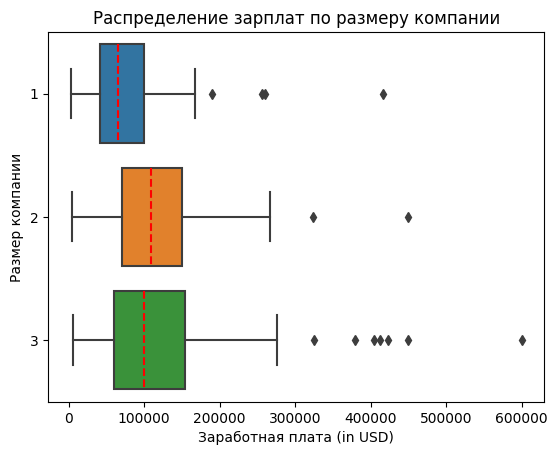

In [323]:
ax = sns.boxplot(data_encoded2, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Заработная плата (in USD)', ylabel='Размер компании')
plt.title('Распределение зарплат по размеру компании')
plt.show()

![](salary_to_size.png)

**Выводы**

Статистический тест показал, что есть зависимость размера зарплат от размера компаний.\
Так как график корреляций нам этого не показал, построили график для наглядности данной информации.\
По нему мы видим, что медианная зарплата выше у компаний M. Это может быть обусловленно тем, что маленькие компании не имеют достаточной вырочки для высоких зарплат, а у больших корпораций возможно больше сотрудников уровня Junior в процентом соотношении с меньшими зарплатами.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: нет связи сежду наличием должностей и размером компании (признаки независимы).

*Альтернативная гипотеза*: между наличием должностей и размером компании есть взаимосвязь (признаки зависимы).


In [330]:
#Оформим дата-сет по необходимым нам параметрам
data_sd = data_encoded2[(data_encoded2['job']==1) | (data_encoded2['job']==2)]
data_sd.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,experience_level,employment_type_0,employment_type_1,employment_type_2,job,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,2,0,0,1,1,3
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,3,0,0,1,2,2
6,2020,SE,FT,Lead Data Scientist,190000,US,100,US,3,0,0,1,1,1
7,2020,MI,FT,Data Scientist,35735,HU,50,HU,2,0,0,1,1,3
9,2020,SE,FT,Lead Data Engineer,125000,NZ,50,NZ,3,0,0,1,2,1


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака "Размер компании"? — Категориальный (порядковый).
* Сколько сравниваемых групп? — Три.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий Краксела — Уоллиса

**Проведём тест**

Так как порядков немного, можно также взглянуть на таблицу сопряженностей:

In [329]:
cross_table = pd.crosstab(data_sd['job'], data_sd['company_size'])

cross_table

company_size,1,2,3
job,,,
1,28,82,69
2,14,86,47


**Выводы**

И таблица сопряженностей, и статистический тест показывает нам на то, что есть взаимосвязь между наличием должностей и 

## Итоговые результаты исследования:

* Есть основания утерждать, что зарплаты специалистов Data Science индексируются ежегодно;
* Данные указывают на то, что у специалистов Data Science зарплаты выше, чем у вспециалистов Data Engineering;
* Медианная зарплата выше в компаниях размера М. Может быть связано с достаточным бюджетом (относительно компаний размера S) и более равноценно распределенным кадровым составом (относительно компаний размера L).
* Наше исследование подтверждает гипотезу о том, что с увеличением опыта работы зарплаты растут вне зависимости от направления.